# Bведение

Данный ноутбук основан на посте https://quantrum.me/875-parnyj-trejding-opisanie-strategii-na-python/

Стратегия парного трейдинга очень популярна на рынке. Она основана на чистой статистике, что делает ее привлекательной для алгоритмической торговли. Общий смысл сводится к нескольким шагам: найти пару, проверить ее поведение, определить границы входа в позицию и направление (лонг/шорт).

Пары ищут с помощью корреляции, но корреляция в чистом виде может сослужить плохую службу. Спред пар должен быть стационарным и обладать коинтегрированностью.

В статье рассмотрены:

Введение в корреляцию/коинтеграцию на простом примере.
Корреляция без коинтеграции.
Коинтеграция без корреляции.

Основные понятия
Временной ряд — статистические данные исследуемого процесса собранные в разные моменты времени.

Корреляция — статистическая взаимосвязь двух и более случайных величин. В нашем случае временных рядов.

Коинтеграция — свойство нескольких нестационарных временных рядов, заключающееся в существовании некоторой их стационарной линейной комбинации.

Стационарность — свойство процесса не менять свои характеристики со временем.

P-значение — величина используемая при тестировании статистических гипотез.

Простыми словами: две акции будут коинтегрированы, когда спред разницы их истории цен будет находиться в пределах фиксированных границ и не будет обладать трендом.

In [1]:
## Пример на сгенерированных данных

Для начала сгенерируем два датасета.
Второй - это то же самое что и первый, сдвинутый на некоторую величину и с добавленным случайным шумом.


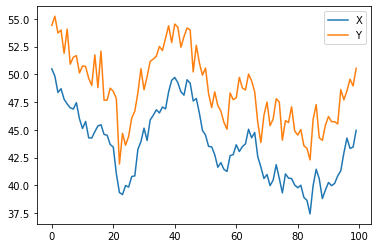

In [2]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import coint,adfuller
import seaborn
import matplotlib.pyplot as plt

 
# устанавливаем зерно для повторимости случайных чисел
np.random.seed(107)
 
X_returns = np.random.normal(0, 1, 100) # генерируем историю доходности
X = pd.Series(np.cumsum(X_returns), name='X') + 50 # суммируем и смещаем на произвольную величину
 
some_noise = np.random.normal(0, 1, 100) # немного шума для второго ряда
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot() # рисуем оба ряда


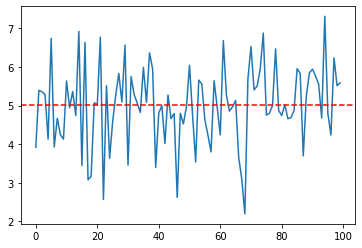

In [3]:
(Y-X).plot() # рисуем спрэд
plt.axhline((Y-X).mean(), color='red', linestyle='--') # добавляем среднее

Проверив значения коинтеграции и корреляции, видим что спред пары стационарен, p-значение рядом с нулем, и имеет высокую корреляцию около 95%. Код для получения значений оценки ниже:

In [4]:

def check_coint_corr(X, Y):
    # проверим стационарность двух рядов
    score, pvalue, _ = coint(X,Y)
    # проверим корреляцию двух рядов
    corr = X.corr(Y)
    print("p-значение: %.4f" % pvalue, "корреляция: %s" % corr)
check_coint_corr(X, Y)

p-значение: 0.0000 корреляция: 0.9497090646385932


Дополнительно проведем тест Дики-Фуллера:
    Он показывает, есть ли  зависимость от времени (тренд) внутри самой серии.
    Если серия стационарна, полученное значение должно быть меньше чем critical value  (1% 5% или 10%- выбирать вам)

In [5]:
def dft(X):
    """
    X- pandas series.
    """
    result = adfuller(X)
    print(f'Checking {X.name} for stationarity')
    score = result[0]
    pvalue = result[1]
    crit = result[4]
    print(f'score is {score}')
    print (f'p-value is {pvalue}')
    print (f'critical values are {crit}')

In [6]:
dft(X)


Checking X for stationarity
score is -2.3030292140497197
p-value is 0.1709928509467194
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


В данном случае мы не можем сказать, что серия стационарна (score > critical value для любого доверительного интервала).

Теперь проверим разницу X-Y:


In [7]:
dft(X-Y)


Checking None for stationarity
score is -10.724034324619938
p-value is 3.0982156802035054e-19
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


В данном случае (как и ожидалось) разница двух рядов стационарна.

Однако, есть случаи, когда ряды имеют высокую корреляцию без коинтеграции. Пара с таким свойством не подходит для парного трейдинга. Для изучения сформируем два независимых произвольных времянных ряда:

p-значение: 0.8816 корреляция: 0.9931343801275687


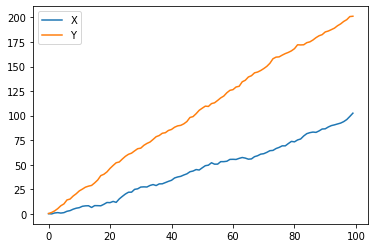

In [8]:
X_returns = np.random.normal(1, 1, 100)
Y_returns = np.random.normal(2, 1, 100)
X_diverging = pd.Series(np.cumsum(X_returns), name='X')
Y_diverging = pd.Series(np.cumsum(Y_returns), name='Y')
pd.concat([X_diverging, Y_diverging], axis=1).plot()
 
check_coint_corr(X_diverging, Y_diverging)

И нарисуем спред:

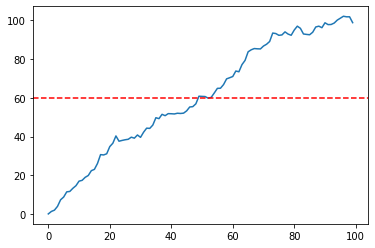

In [9]:
(Y_diverging-X_diverging).plot() # рисуем спрэд
plt.axhline((Y_diverging-X_diverging).mean(), color='red', linestyle='--') # добавляем среднее

Видим, что оба ряда имеют высокую корреляцию около 99% и проваливают тест на коинтеграцию с p-значением 0.881 (рядом с единицей). Мы видим, что спред имеет тенденцию роста со временем.

Так же проведем тест Дики-фуллера на одной из переменных и на их разнице:

In [10]:
dft(X_diverging)


Checking X for stationarity
score is 2.04915366037777
p-value is 0.9987335147618978
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


Серия не стационарна

In [11]:
dft(Y_diverging-X_diverging)


Checking None for stationarity
score is -2.619137569616801
p-value is 0.08910607539960957
critical values are {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}


То же самое можно сказать о разнице: если мы сравним с доверительным интервалом хотя бы 5% ( это означает что есть 5% вероятность того что полученные результаты случайны)- увидим что разница имеет тренд- что опять же не есть хорошо.

## Реальный пример

В данном примере мы возьмем две случайные акции, и проведем такой же визуальный анализ как показано выше.

In [12]:
#importing the libraries
import pandas as pd
import sys
sys.path.append('../src/data')
import ClickhouseHelper as chh

Скачаем минутные данные по ETF с начала 2020 года:

    
Кстати, ETF я использую исключительно для примера- размер получаемого датафрейма самый маленький.
В дальнейшем подобный подход будем использовать на акциях.

In [13]:
con=chh.connect(instance_name="localhost")

generated an exception: 'NoneType' object has no attribute 'encode'


In [14]:
df=chh.query_data_by_time(
    channels_list=[],
    startTime=None,
    endTime=None,
    days_span=360,    
    server_ip="192.168.1.128",
    table_name="minutes",
    instrument_type="Stock",
    data_freq="min",
)

generated an exception: 'NoneType' object has no attribute 'encode'


AttributeError: 'NoneType' object has no attribute 'execute'

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df.tail()

In [ ]:
# отфильтруем только по рублевым ETF
df=df[df.currency=='RUB']

In [ ]:
# опять же для примера- нарисуем графики ETF vs Time

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

for n, grp in df.groupby('ticker'):
    ax.scatter(x = "day", y = "c", data=grp, label=n)
ax.legend(title="Label")

plt.show()

Видим, что по коричневой и красным кривым ( FXUK, FXWO данные почему то скачались только до середины февраля.)

In [ ]:
#Проверим длину ( количество значений) по каждому из ETF.
#Для анализа критичным является то, что при сравнении и расчете коинтеграции и корелляции длина временных рядов должна быть одинаковой.
all_lengths=[]
for etf in df.ticker.unique():
    print(f'shape of ETF {etf} {df[df.ticker==etf].name.unique()[0]} is: {df[df.ticker==etf].shape[0]}')
    
    all_lengths.append(df[df.ticker==etf].shape[0])

In [ ]:
length_limit = int(np.percentile(all_lengths, 10))

In [ ]:
length_limit

In [ ]:
#keeping only tickers with len>len_limit:
for etf in df.ticker.unique():
    if df[df.ticker==etf].shape[0]<=length_limit:
        df = df[df.ticker != etf]


In [ ]:
def get_performance(a):
    """
    Конвертируем историю в относительные величины
    
    """
    a=a.values
    return np.insert(np.cumsum(np.diff(a) / a[:-1] * 100.), 0, 0)

In [ ]:
#Готовим данные для анализа: рассчитываем кумулятивную сумму дельт ( в % роста или падения от предыдущего дня)
df['c_cumsum']=df.groupby('ticker')['c'].transform(get_performance)
df['o_cumsum']=df.groupby('ticker')['o'].transform(get_performance)


In [ ]:
# проверяем коинтеграцию и удаляем стационарные ряды
for ticker in df.ticker.unique():
    result = adfuller(df[df.ticker==ticker].c_cumsum.values)
    score = result[0]
    pvalue = result[1]
    crit = result[4]
    if score<crit['1%']: 
        print(f'ticker {ticker} is cointegrated. Deleting it.')
        df=df[df.ticker!=ticker]

In [ ]:


for n, grp in df.groupby('ticker'):
    fig, ax = plt.subplots(figsize=(8,2))
    ax.scatter(x = "day", y = "c_cumsum", data=grp, label=n)
    ax.legend(title="Label")
    plt.show()



In [ ]:
#let's pivot table for simplicity
c_cumsum=df.pivot(index='day',columns='ticker',values='c_cumsum')
o_cumsum=df.pivot(index='day',columns='ticker',values='o_cumsum')

Следующий шаг- выберем случайно две колонки и построим их значения, так же значения их разницы.


In [ ]:
c_cumsum.columns

In [ ]:
ABRD=c_cumsum.ABRD
AFKS=c_cumsum.AFKS
pd.concat([ABRD, AFKS], axis=1).plot()
 
check_coint_corr(ABRD, AFKS)

plt.show()
plt.figure()
(ABRD-AFKS).plot() # рисуем спрэд
plt.axhline((ABRD-AFKS).mean(), color='red', linestyle='--') # добавляем среднее
plt.show()

Видим, что оба ряда имеют низкую корреляцию около 10% и проваливают тест на коинтеграцию с p-значением 0.91 (рядом с единицей). Мы видим, что спред имеет временную зависимость.

Проведем тест Дики-Фуллера:
    

In [ ]:
dft(ABRD)

Серия не стационарна

In [ ]:
dft(ABRD-AFKS)

Аналогично, данная серия не стационарна ( на горизонте 12-ти месяцев, и использовать ее нельзя)

In [ ]:
## Автоматический подбор пар

Ну а сейчас - немного мяса. 
Давайте поищем пары среди ETF для парной торговли.


Данный тест проверяет времянной ряд (историю изменения цены) на стационарность (наличие коинтеграции). Осуществляется проверка наличия у времянного ряда единичного корня, о чем подробнее написано в Вики. Реализован в библиотеке statsmodels.

Функция проверки стационарности:
[code python]statsmodels.tsa.stattools.adfuller(X)[/code]

Выбираем пары с оценкой ниже 5% критического порога и p-значением меньше 0,001. Код поиска пар ниже:

In [ ]:
c_cumsum.columns

In [ ]:
c_cumsum.head()

In [ ]:
c_cumsum.shape

In [ ]:
c_cumsum.isnull().sum()

In [ ]:
c_cumsum.dropna(axis=0, how='any', inplace=True)

In [ ]:
c_cumsum.shape

In [ ]:
n = len(c_cumsum.columns)
score_matrix = np.zeros((n, n))
pvalue_matrix = np.ones((n, n))

symbols = c_cumsum.columns.to_list()
pairs = []

In [ ]:
symbols

In [ ]:
for i in range(n):
        for j in range(i+1, n):
            S1 = c_cumsum[symbols[i]]
            S2 = c_cumsum[symbols[j]]
            
            # подготавливаем ряды, если надо
            #if need_preparation:
            #   S1, S2 = prepare_vectors(S1, S2, to_performance=True)
                
            # проверяем коинтеграцию
            print(f"comparing {S1.name} and {S2.name}")
            if S1.shape[0]==S2.shape[0]:
                result = adfuller(S1-S2)
                # заполняем матрицы значений
                score = result[0]
                pvalue = result[1]
                crit = result[4]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                # добавляем пары без единичных корней с p-значением менее 0.001
                if score < crit['5%'] and pvalue < 0.001:
                    pairs.append((symbols[i], symbols[j], pvalue))



In [ ]:
pairs

In [ ]:
# сортируем пары по возрастанию p-значения
import operator
sorted_pairs = sorted(pairs, key=operator.itemgetter(2))

In [ ]:
sorted_pairs

In [ ]:
#Давайте теперь сравним парочку значений более детально:
MGNT=c_cumsum.MGNT
TRMK=c_cumsum.TRMK
pd.concat([MGNT, TRMK], axis=1).plot()
 
check_coint_corr(MGNT, TRMK)

plt.show()
plt.figure()
(MGNT-TRMK).plot() # рисуем спрэд
plt.axhline((MGNT-TRMK).mean(), color='red', linestyle='--') # добавляем среднее
plt.show()

In [ ]:
def find_cointegrated_pairs_adf(df, need_preparation=False):
    # готовим матрицы для сбора оценок и p-значений
    n = len(df.columns)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    
    symbols = df.columns.to_list()
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            S1 = symbol_prices[symbols[i]]
            S2 = symbol_prices[symbols[j]]
            
            # подготавливаем ряды, если надо
            if need_preparation:
                S1, S2 = prepare_vectors(S1, S2, to_performance=True)
                
            # проверяем коинтеграцию
            result = adfuller(S1-S2)
            # заполняем матрицы значений
            score = result[0]
            pvalue = result[1]
            crit = result[4]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            # добавляем пары без единичных корней с p-значением менее 0.001
            if score < crit['5%'] and pvalue < 0.001:
                pairs.append((symbols[i], symbols[j], pvalue))
                
    # сортируем пары по возрастанию p-значения
    sorted_pairs = sorted(pairs, key=operator.itemgetter(2))
    return score_matrix, pvalue_matrix, sorted_pairs